## General information

In this kernel I work with a dataset for the Food Recognition Challenge conducted on AIcrowd hosted here: https://www.aicrowd.com/challenges/food-recognition-challenge.
```
This is a novel dataset of food images collected through the MyFoodRepo app where numerous volunteer Swiss users provide images of their daily food intake in the context of a digital cohort called Food & You. This growing data set has been annotated - or automatic annotations have been verified - with respect to segmentation, classification (mapping the individual food items onto an ontology of Swiss Food items), and weight / volume estimation.

This is an evolving dataset, where we will release more data as the dataset grows over time.
```

![](https://i.imgur.com/Syv1Ycf.png)

In this kernel I'll show how to set up environment for this challenge, provide EDA and possible in future show baseline modelling.

The code is based on this notebook by organizers: https://colab.research.google.com/drive/1A5p9GX5X3n6OMtLjfhnH6Oeq13tWNtFO#scrollTo=lkjrKJfIVCM3

## Setting up environment

There are several steps which need to be done:
* install certain versions of numpy, tensorflow, keras
* clone the Mask_RCNN repo
* install requirements and the repo itself
* the utils reqires json with annotations to be called `annotation.json`, but we have `annotations.json`; so I copy the whole data and copy this file with a new name

In [1]:
!rm -rf images assets
!pip install numpy==1.17.0
!pip install tensorflow==1.15.2
!pip install keras==2.1.0

     |████████████████████████████████| 20.4 MB 2.8 MB/s 
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.6.2 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.17.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: hyperopt 0.2.3 has requirement networkx==2.2, but you'll have networkx 2.4 which is incompatible.
ERROR: dask-ml 1.2.0 has requirement numpy>=1.17.3, but you'll have numpy 1.17.0 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.

In [2]:
import os
DATA_DIR = '/kaggle/working/food-recognition-challenge'
# Directory to save logs and trained model
ROOT_DIR = ''

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!pip install -q -r requirements.txt
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 48.25 MiB/s, done.
Resolving deltas: 100% (570/570), done.
zip_safe flag not set; analyzing archive contents...


In [4]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

### import libraries

In [5]:
import sys
sys.path.append(os.path.join('.', 'Mask_RCNN'))  # To find local version of the library
sys.path.append(ROOT_DIR)
import sys
import re
import random
import pandas as pd 
import os 
import numpy as np
import mrcnn.model as modellib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib
import math
import logging
import json
import itertools
import glob 
import cv2
from tqdm import tqdm
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import utils
from matplotlib.patches import Polygon
from imgaug import augmenters as iaa
from collections import defaultdict, Counter
from collections import OrderedDict
ROOT_DIR = os.path.abspath(".")

Using TensorFlow backend.


### Defining dataset class and config

In [6]:
class FoodChallengeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, load_small=False, return_coco=True):
        """ Loads dataset released for the AICrowd Food Challenge
            Params:
                - dataset_dir : root directory of the dataset (can point to the train/val folder)
                - load_small : Boolean value which signals if the annotations for all the images need to be loaded into the memory,
                               or if only a small subset of the same should be loaded into memory
        """
        self.load_small = load_small
        if self.load_small:
            annotation_path = os.path.join(dataset_dir, "annotation-small.json")
        else:
            annotation_path = os.path.join(dataset_dir, "annotations.json")

        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()

        # Load all images
        image_ids = list(self.coco.imgs.keys())

        # register classes
        for _class_id in classIds:
            self.add_class("crowdai-food-challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "crowdai-food-challenge", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks
                    (In this version of the challenge it will be of shape [instances] and always be filled with the class-id of the "Building" class.)
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "crowdai-food-challenge"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "crowdai-food-challenge.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FoodChallengeDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        """Return a reference for a particular image

            Ideally you this function is supposed to return a URL
            but in this case, we will simply return the image_id
        """
        return "crowdai-food-challenge::{}".format(image_id)
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

### Warning

Please, notice that in config values of `STEPS_PER_EPOCH` and `VALIDATION_STEPS` are quite low. I decreased them so that model would train fast, but the quality will be low. When you train the model, increase the values up to 50-200.

In [7]:
from mrcnn.config import Config
class FoodChallengeConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "crowdai-food-challenge"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    BACKBONE = 'resnet50'
    # Number of classes (including background)
    NUM_CLASSES = 62  # 1 Background + 61 classes

    STEPS_PER_EPOCH=10
    VALIDATION_STEPS=10

    LEARNING_RATE=0.001
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
config = FoodChallengeConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
%cd ..
!cp /kaggle/input/food-recognition-challenge /kaggle/working -r
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

/kaggle/working


In [9]:
!cp /kaggle/working/food-recognition-challenge/train/train/annotations.json /kaggle/working/food-recognition-challenge/train/train/annotation.json

In [10]:
#from mrcnn.dataset import FoodChallengeDataset
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(dataset_dir=os.path.join("/kaggle/working/food-recognition-challenge/train", "train"), load_small=False)
#dataset_train.load_dataset(dataset_dir="train", load_small=False)
dataset_train.prepare()
dataset = dataset_train

Annotation Path  /kaggle/working/food-recognition-challenge/train/train/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/train/train/images
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


## Data exploration

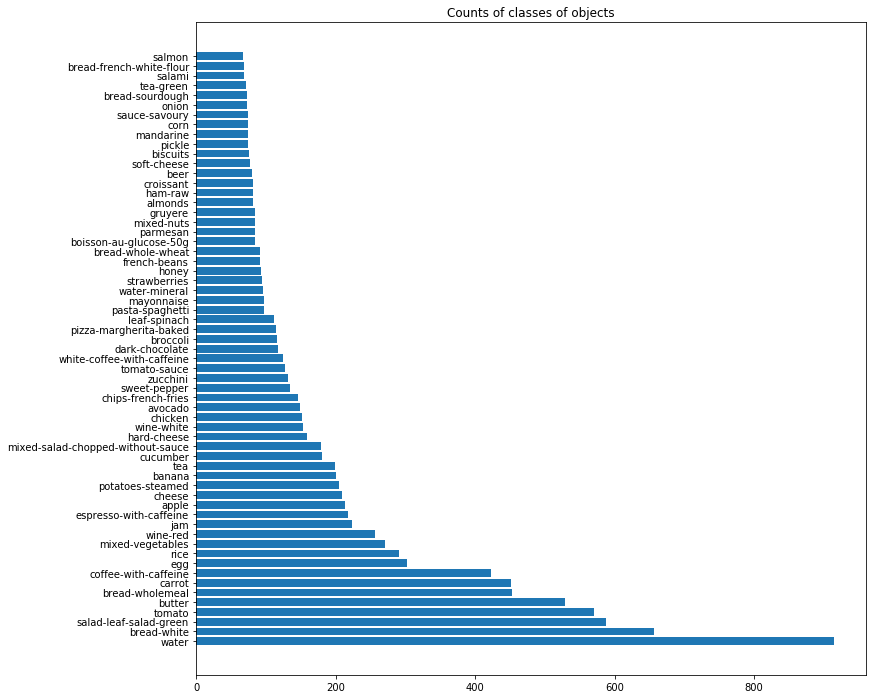

In [11]:
from collections import Counter
class_counts = Counter()
for img_info in dataset_train.image_info:
    ann = img_info['annotations']
    for i in ann:
        class_counts[i['category_id']] += 1
class_mapping = {i['id']: i['name'] for i in dataset_train.class_info}

class_counts = pd.DataFrame(class_counts.most_common(), columns=['class_name', 'count'])
class_counts['class_name'] = class_counts['class_name'].apply(lambda x: class_mapping[x])
plt.figure(figsize=(12, 12))
plt.barh(class_counts['class_name'], class_counts['count'])
plt.title('Counts of classes of objects');

In [12]:
print(f'We have {class_counts.shape[0]} classes!')

We have 61 classes!


The most common is water - I suppose it is a background. Some vegetables and white bread are the most common.

Now let's use a function from the repo to see information about one random image

image_id  1158 crowdai-food-challenge::1158
image                    shape: (391, 392, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (391, 392, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    9.00000  max:    9.00000  int32
bbox                     shape: (1, 4)                min:    2.00000  max:  285.00000  int32


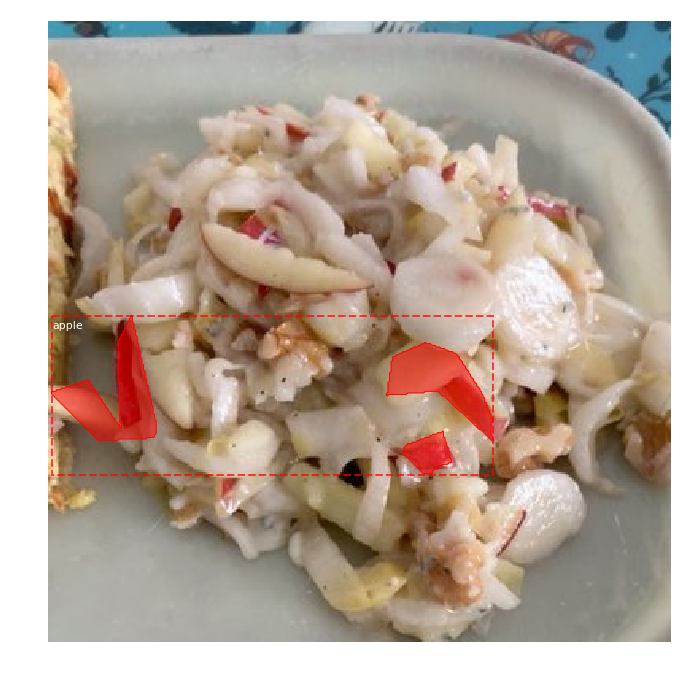

In [13]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(12, 12))

Let's see what information we have about images:

In [14]:
dataset_train.image_info[0]

{'id': 65561,
 'source': 'crowdai-food-challenge',
 'path': '/kaggle/working/food-recognition-challenge/train/train/images/065561.jpg',
 'width': 464,
 'height': 464,
 'annotations': [{'id': 102450,
   'image_id': 65561,
   'category_id': 2578,
   'segmentation': [[235.0,
     337.5,
     190.0,
     333.5,
     180.5,
     328.0,
     174.5,
     315.0,
     157.5,
     231.0,
     148.5,
     158.0,
     138.5,
     112.0,
     138.5,
     79.0,
     145.5,
     60.00000000000001,
     151.0,
     57.5,
     180.0,
     57.5,
     207.0,
     62.50000000000001,
     245.00000000000003,
     55.5,
     280.0,
     57.5,
     292.5,
     67.0,
     308.5,
     91.0,
     311.5,
     110.0,
     310.5,
     137.0,
     303.5,
     182.0,
     297.5,
     261.0,
     288.5,
     306.0,
     283.5,
     318.0,
     271.0,
     331.5,
     261.0,
     335.5]],
   'area': 40035.0,
   'bbox': [57.5, 138.5, 280.0, 173.0],
   'iscrowd': 0}]}

* There is some meta information: path, height, width
* for each object we have annotatioins: class, segmentation mask, total area, bbox coordinates.

### Masks

We can see masks and boxes for different classes. Let's take 10 random classes

In [15]:
class_images = defaultdict(list)
for ind, img_info in enumerate(dataset_train.image_info):
    ann = img_info['annotations']
    for i in ann:
        class_images[i['category_id']].append(ind)

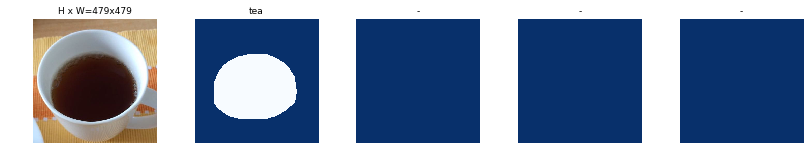

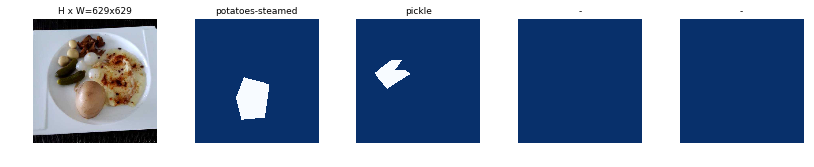

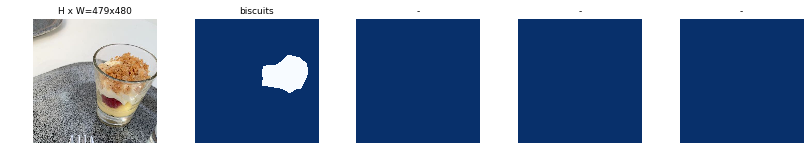

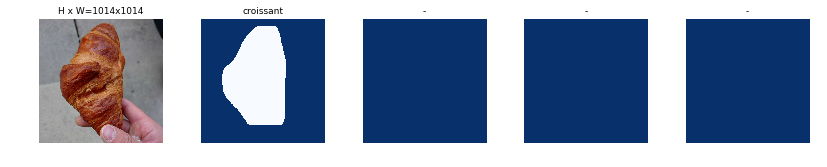

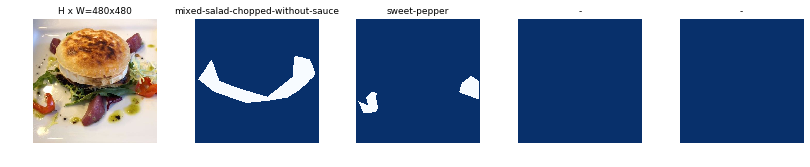

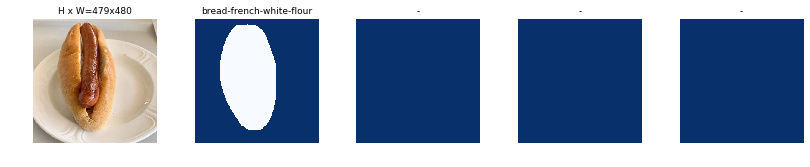

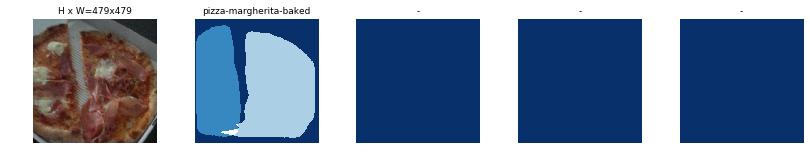

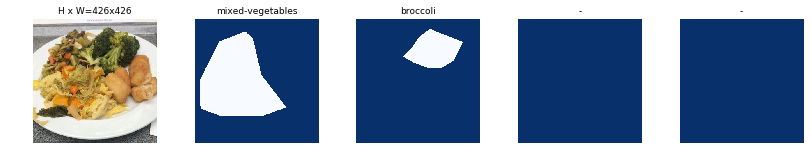

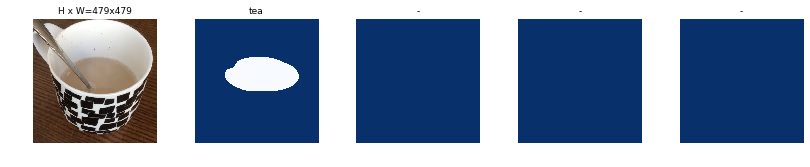

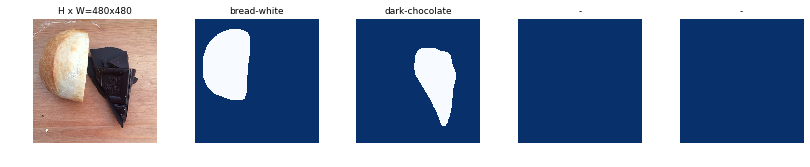

In [16]:
image_ids = np.random.choice(dataset.image_ids, 4)
for class_id in np.random.choice(list(class_images.keys()), 10):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

We can see that some masks are big, some are small. Some have a single area, some have multiple areas.

### Bounding Boxes

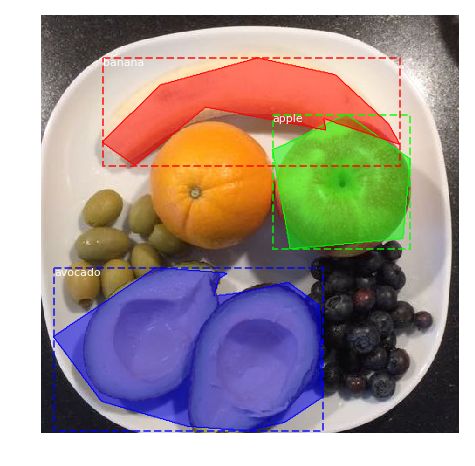

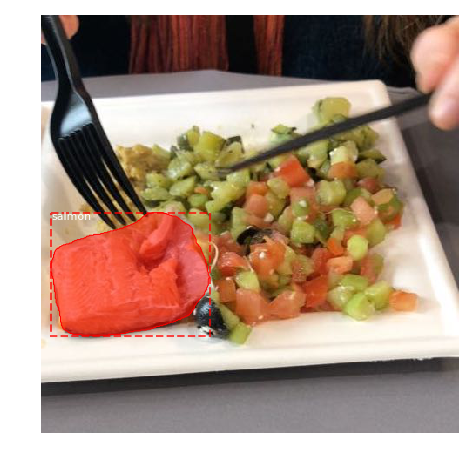

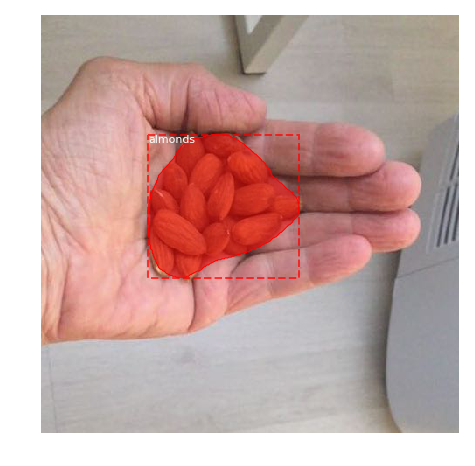

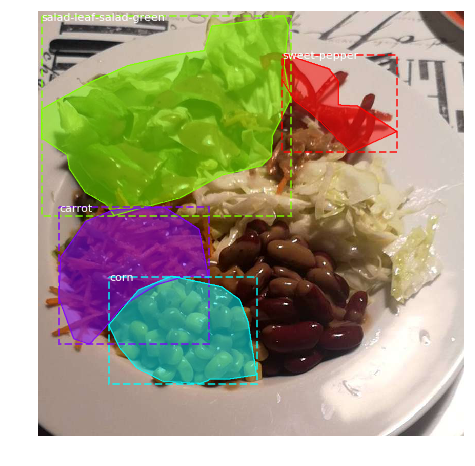

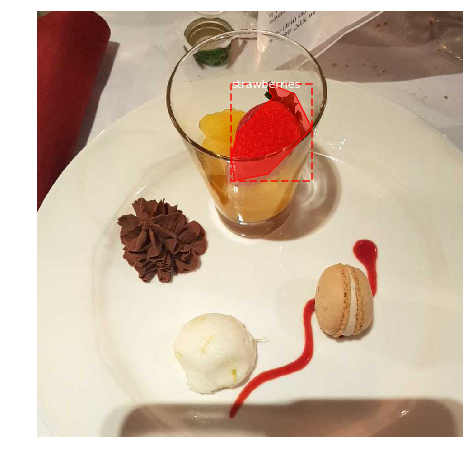

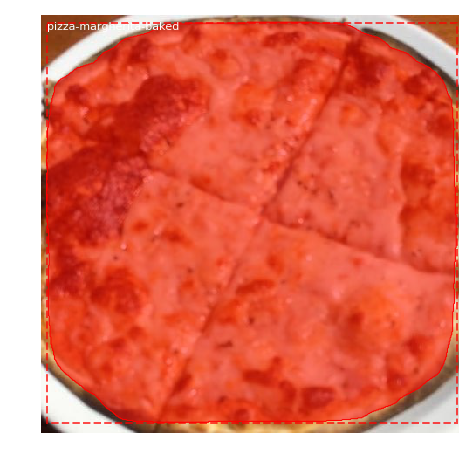

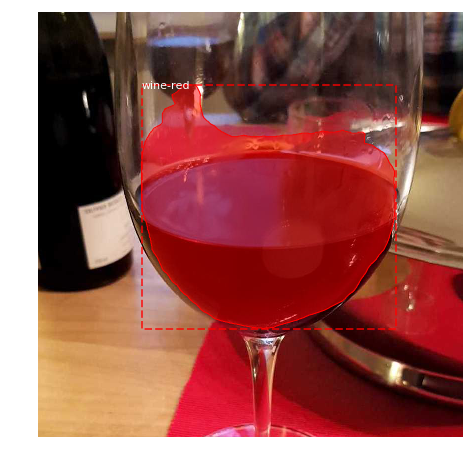

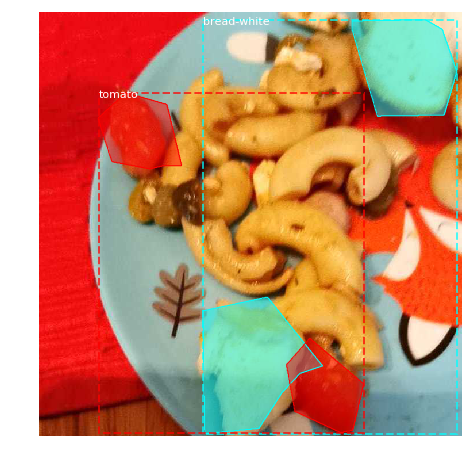

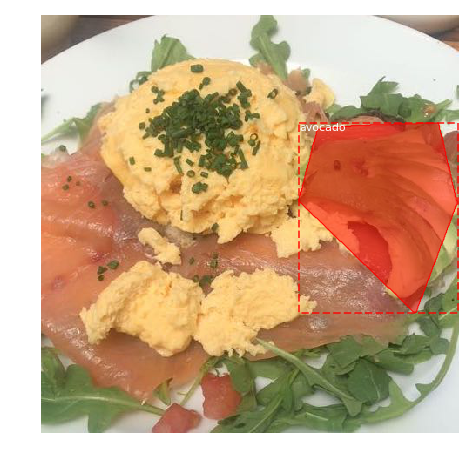

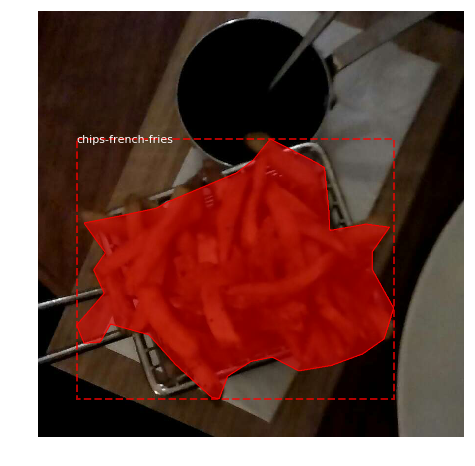

In [17]:
for idx, class_id in enumerate(np.random.choice(list(class_images.keys()), 10)):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(8, 8))

Obviously bounding boxed have masks inside them. And if an object has several masks, then the bounding box will contain all the masks.

### Anchors

One more important type of annotatioin is anchor. Anchors are a set of boxes with predefined locations and scales relative to images. These boxes are defined to capture the scale and aspect ratio of specific object classes you want to detect and are typically chosen based on object sizes in your training datasets.

In [18]:
# Generate Anchors

backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  16368
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48


Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


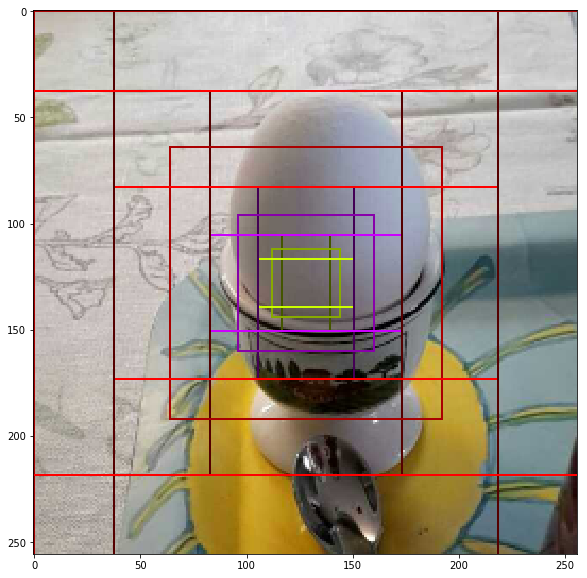

In [19]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

BG                     : 134
mixed-vegetables       : 66


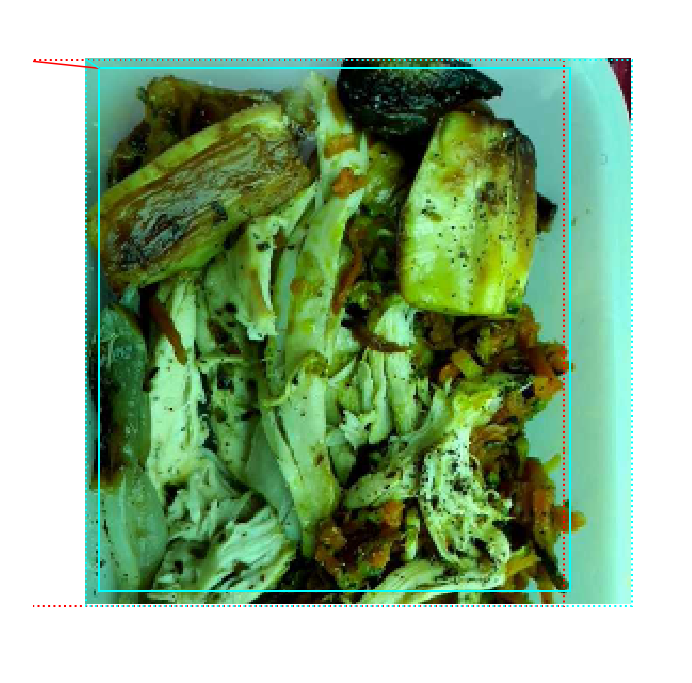

In [20]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

### ROI
Region of interest pooling (also known as RoI pooling) is an operation widely used in object detection tasks using convolutional neural networks. For example, to detect multiple fruits and vegetables in a single image. Its purpose is to perform max pooling on inputs of nonuniform sizes to obtain fixed-size feature maps (e.g. 7×7).

The result is that from a list of rectangles with different sizes we can quickly get a list of corresponding feature maps with a fixed size. Note that the dimension of the RoI pooling output doesn’t actually depend on the size of the input feature map nor on the size of the region proposals. It’s determined solely by the number of sections we divide the proposal into. What’s the benefit of RoI pooling? One of them is processing speed. If there are multiple object proposals on the frame (and usually there’ll be a lot of them), we can still use the same input feature map for all of them. Since computing the convolutions at early stages of processing is very expensive, this approach can save us a lot of time.

Positive ROIs:  66
Negative ROIs:  134
Positive Ratio: 0.33
Unique ROIs: 200 out of 200


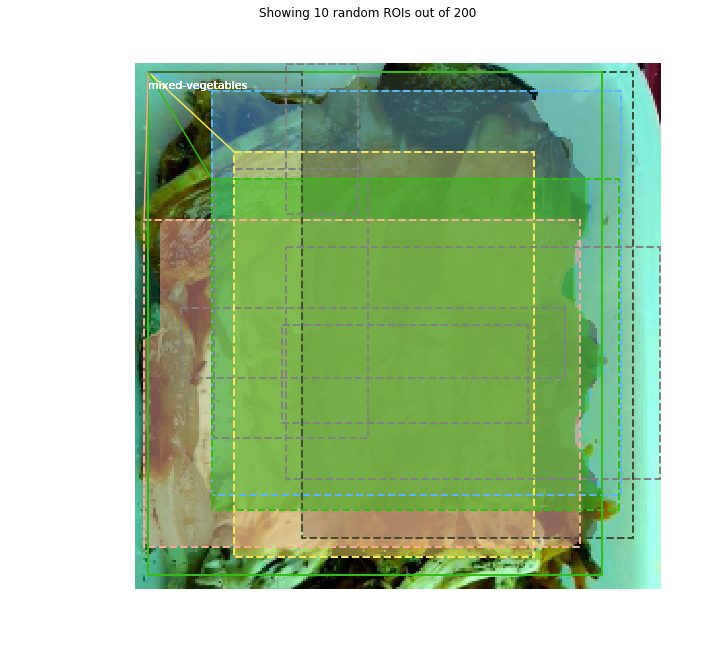

In [21]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

## Modelling with Mask-RCNN

The code is based on the baseling by organizers:
https://discourse.aicrowd.com/t/new-starter-notebook-paperspace/2754/1

In [22]:
!mkdir pretrained

In [23]:
PRETRAINED_MODEL_PATH = os.path.join("pretrained", "mask_rcnn_coco.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
if not os.path.exists(PRETRAINED_MODEL_PATH):
    utils.download_trained_weights(PRETRAINED_MODEL_PATH)

... done downloading pretrained model!


In [24]:
import keras.backend
K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.common.image_dim_ordering()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])

In [25]:
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(os.path.join("/kaggle/working/food-recognition-challenge/train", "train"), load_small=False)
dataset_train.prepare()
dataset_val = FoodChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir=os.path.join("/kaggle/working/food-recognition-challenge/val", "val"), load_small=False, return_coco=True)
dataset_val.prepare()

Annotation Path  /kaggle/working/food-recognition-challenge/train/train/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/train/train/images
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
Annotation Path  /kaggle/working/food-recognition-challenge/val/val/annotations.json
Image Dir  /kaggle/working/food-recognition-challenge/val/val/images
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [26]:
class_names = dataset_train.class_names
assert len(class_names)==62, "Please check DatasetConfig"

In [27]:
print("Training network")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')

Training network

Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/Mask_RCNN/logs/crowdai-food-challenge20200331T0232/mask_rcnn_crowdai-food-challenge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/1
 9/10 [==========================>...] - ETA: 48s - loss: 5.5441 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.1211 - mrcnn_class_loss: 2.5968 - mrcnn_bbox_loss: 0.9868 - mrcnn_mask_loss: 0.7861 

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


10/10 [==============================] - 570s 57s/step - loss: 5.4483 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.2156 - mrcnn_class_loss: 2.3972 - mrcnn_bbox_loss: 0.9984 - mrcnn_mask_loss: 0.7748 - val_loss: 3.1090 - val_rpn_class_loss: 0.0576 - val_rpn_bbox_loss: 0.7176 - val_mrcnn_class_loss: 0.6629 - val_mrcnn_bbox_loss: 0.9465 - val_mrcnn_mask_loss: 0.7244


## Looking at the predictions

In [28]:
model_path = model.find_last()
model_path

'/kaggle/working/Mask_RCNN/logs/crowdai-food-challenge20200331T0232/mask_rcnn_crowdai-food-challenge_0001.h5'

In [29]:
# I'll use my model trained locally
model_path = '/kaggle/input/food-model/mask_rcnn_crowdai-food-challenge_0010.h5'

In [30]:
class InferenceConfig(FoodChallengeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 62  # 1 Background + 61 classes
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    NAME = "food"
    DETECTION_MIN_CONFIDENCE=0

inference_config = InferenceConfig()
inference_config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [31]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/input/food-model/mask_rcnn_crowdai-food-challenge_0010.h5


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


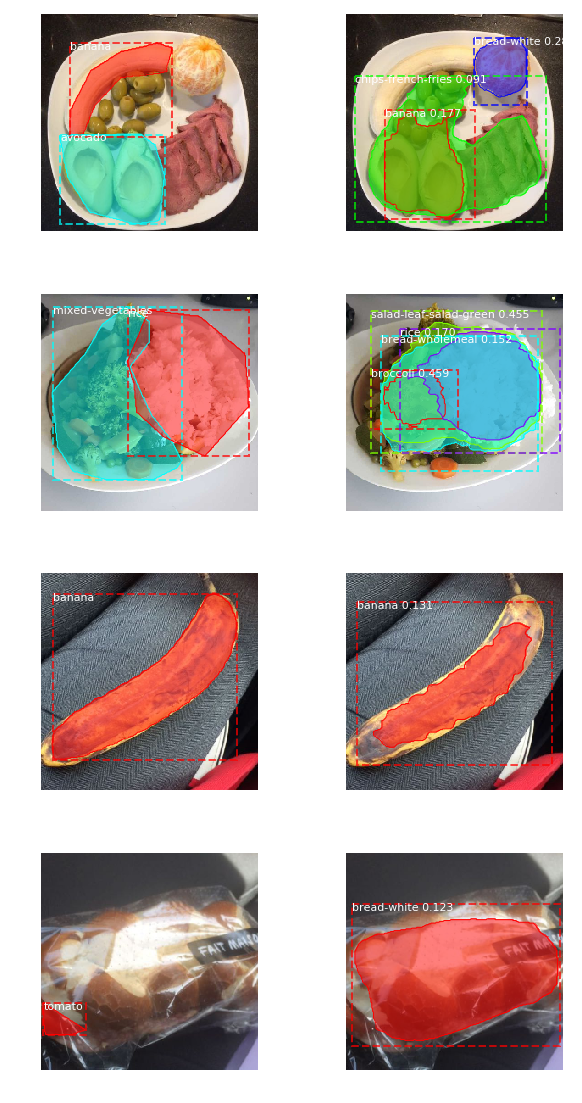

In [32]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])